# %% [markdown]
# Project Notebook: Classification of y from x1,...,x10

Welcome! The goal of this notebook is to explains the steps needed to:
- Load and explore a dataset with columns x1,...,x10 plus the label y.
- Perform data cleaning (e.g., outlier removal), train/test splitting, and standardization being mindful of data leakage.
- Train and evaluate from-scratch (no scikit-learn!) implementations of:
   1) Perceptron
   2) Pegasos SVM (hinge loss)
   3) Pegasos Logistic (logistic loss)
   4) Polynomial feature expansion (degree 2)
   5) Kernel Perceptron (Gaussian & polynomial kernels)
   6) Kernel Pegasos SVM (Gaussian & polynomial kernels)
- Assess model performance using 0-1 loss (equivalently, accuracy).



In [1]:
# Basic Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import your custom functions/classes from functions.py (adjust as needed).
from ml_functions import (
    # Data utilities
    remove_outliers_from_file,
    split_and_standardize_data,
    impute_missing_values,
    to_pm1_labels,

    # Models
    Perceptron,
    PegasosSVM,
    PegasosLogistic,
    KernelPerceptron,
    KernelPegasosSVM,

    # Feature expansion and kernel utilities
    polynomial_feature_expansion,
    gaussian_kernel,
    polynomial_kernel,

    # Metrics
    accuracy_score,
    zero_one_loss
)

%matplotlib inline


In [ ]:

# 1. Load and Inspect the Dataset

# File path
csv_file = "/Users/michelecoaro/Documents/GitHub/KLC/klc_project/dataset.csv"  # Adjust if needed

# Read the dataset into a DataFrame
df = pd.read_csv(csv_file)

print("Shape of the raw dataset:", df.shape)
df.head()


Shape of the raw dataset: (10000, 11)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.205492,5.823226,98.837539,-1.075852,0.999205,0.911543,3.623558,-1.720267,-0.346191,-54.708330,-1
1,1.391530,3.611581,98.857197,-5.020318,0.677165,0.999492,3.413112,4.253865,2.041603,-54.317291,1
2,1.692571,-0.887019,100.901276,-0.595548,0.177550,-0.915495,4.320264,0.907834,3.126815,-56.397484,-1
3,4.289320,1.416843,100.784735,-2.897154,-0.066972,-0.786173,2.093003,1.336237,2.183829,-56.197728,1
4,0.542420,-1.010095,100.015580,-3.070705,0.088324,-0.242669,0.767942,-0.284683,-2.104145,-55.794045,1


In [5]:
'''
Quick Exploratory Data Analysis
We'll do a few basic checks: df.info(), df.describe(), etc.
You can add more EDA as needed.
'''


df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
 3   x4      10000 non-null  float64
 4   x5      10000 non-null  float64
 5   x6      10000 non-null  float64
 6   x7      10000 non-null  float64
 7   x8      10000 non-null  float64
 8   x9      10000 non-null  float64
 9   x10     10000 non-null  float64
 10  y       10000 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.591298,0.515879,99.848936,-1.504139,0.077645,0.051823,0.975207,0.635194,0.051926,-55.447678,-0.001600
std,1.321185,2.054488,0.710948,1.133605,0.707270,0.704755,2.162237,2.212708,1.769646,0.710082,1.000049
min,0.002443,-7.524934,98.572455,-7.078939,-1.000000,-1.000000,-6.906971,-7.140755,-7.151890,-56.773931,-1.000000
25%,0.524758,-0.883862,99.159314,-2.179713,-0.624710,-0.644261,-0.500506,-0.879985,-1.129665,-56.137679,-1.000000
50%,1.276243,0.492813,99.802830,-1.262985,0.157145,0.101648,1.006918,0.624762,0.024726,-55.397208,-1.000000
75%,2.352106,1.902003,100.549141,-0.605316,0.777856,0.754770,2.434886,2.098389,1.248961,-54.758351,1.000000
max,9.384223,8.302375,101.260768,-0.000003,1.000000,1.000000,8.760306,9.287266,6.211452,-54.208890,1.000000


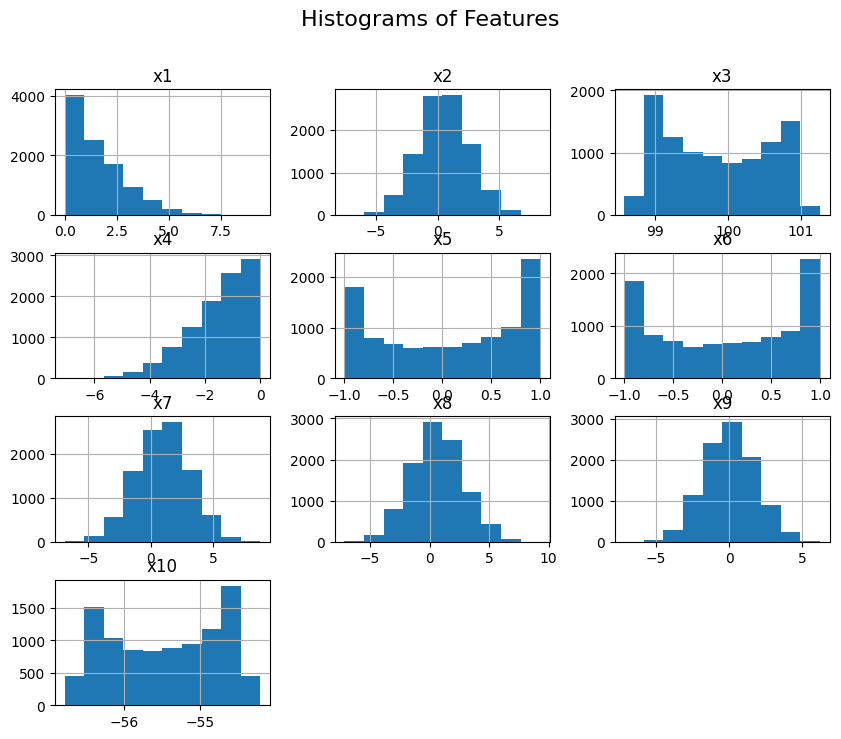

Correlation matrix:
            x1        x2        x3        x4        x5        x6        x7  \
x1   1.000000  0.213794 -0.059941 -0.107913 -0.069695  0.059450  0.157192   
x2   0.213794  1.000000 -0.036847 -0.146139 -0.033884  0.035874  0.193332   
x3  -0.059941 -0.036847  1.000000  0.038096  0.006647 -0.990158 -0.072462   
x4  -0.107913 -0.146139  0.038096  1.000000  0.060270 -0.037245 -0.106705   
x5  -0.069695 -0.033884  0.006647  0.060270  1.000000 -0.005960 -0.050388   
x6   0.059450  0.035874 -0.990158 -0.037245 -0.005960  1.000000  0.071362   
x7   0.157192  0.193332 -0.072462 -0.106705 -0.050388  0.071362  1.000000   
x8   0.223806  0.239564 -0.051349 -0.144265 -0.140856  0.049723  0.334096   
x9   0.429268  0.329018 -0.028337 -0.072148 -0.130413  0.026130  0.306482   
x10  0.058455  0.036350 -0.979901 -0.035631 -0.005754  0.989845  0.070218   
y    0.219823  0.105165  0.056483 -0.203853  0.068666 -0.057853  0.261017   

           x8        x9       x10         y  
x1   0.2

In [6]:
# Histograms of features (excluding label y)
df.drop("y", axis=1).hist(figsize=(10, 8))
plt.suptitle("Histograms of Features", fontsize=16)
plt.show()

# Correlation matrix
corr_matrix = df.corr()
print("Correlation matrix:\n", corr_matrix)

2. Outlier removal.

- Removes rows beyond a certain z-score threshold. 
- This overwrites your original CSV. 
- Comment this part out if you don't want to change your original file.

In [7]:
remove_outliers_from_file(csv_file, threshold=3.0, columns=[f"x{i}" for i in range(1,11)])
df = pd.read_csv(csv_file)
print("Shape after outlier removal:", df.shape)

Removed 265 outliers from /Users/michelecoaro/Documents/GitHub/KLC/klc_project/dataset.csv
Shape after outlier removal: (9735, 11)


3. Prepare the Data for Modeling
- Separate X, y
- Convert y to {+1, -1}
- Split (train/test), standardize (to avoid leakage)
- (Optional) Impute missing values

In [8]:
# Separate X and y
X = df[[f"x{i}" for i in range(1, 11)]].values
y = df["y"].values

# Convert labels if they aren't already in {+1, -1}.
y = to_pm1_labels(y)

# Split & standardize
X_train, X_test, y_train, y_test = split_and_standardize_data(
    X, y, test_ratio=0.2, random_state=42
)

# If needed, impute missing values:
# X_train, X_test = impute_missing_values(X_train, X_test, strategy='median')

print("Training set shape:", X_train.shape)
print("Test set shape:    ", X_test.shape)


Training set shape: (7788, 10)
Test set shape:     (1947, 10)


### 4. Train and Evaluate Linear Models

#### 4.1 Perceptron

In [9]:
perc = Perceptron(max_iter=10, shuffle=True, random_state=42)
perc.fit(X_train, y_train)

y_pred_perc = perc.predict(X_test)
acc_perc = accuracy_score(y_test, y_pred_perc)
loss_perc = zero_one_loss(y_test, y_pred_perc)

print("[Perceptron]")
print(f"Test Accuracy = {acc_perc * 100:.2f}%")
print(f"0-1 Loss      = {loss_perc:.3f}")


[Perceptron]
Test Accuracy = 68.36%
0-1 Loss      = 0.316


#### 4.2 Pegasos SVM (Hinge Loss)


In [10]:

svm = PegasosSVM(lambda_=1e-4, max_iter=1000, random_state=42)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
loss_svm = zero_one_loss(y_test, y_pred_svm)

print("[Pegasos SVM]")
print(f"Test Accuracy = {acc_svm * 100:.2f}%")
print(f"0-1 Loss      = {loss_svm:.3f}")


[Pegasos SVM]
Test Accuracy = 54.90%
0-1 Loss      = 0.451


In [11]:
# %% [markdown]
# ### 4.3 Pegasos Logistic (Logistic Loss)

# %%
logi = PegasosLogistic(lambda_=1e-4, max_iter=1000, random_state=42)
logi.fit(X_train, y_train)

y_pred_logi = logi.predict(X_test)
acc_logi = accuracy_score(y_test, y_pred_logi)
loss_logi = zero_one_loss(y_test, y_pred_logi)

print("[Pegasos Logistic]")
print(f"Test Accuracy = {acc_logi * 100:.2f}%")
print(f"0-1 Loss      = {loss_logi:.3f}")


[Pegasos Logistic]
Test Accuracy = 55.98%
0-1 Loss      = 0.440


/Users/michelecoaro/Documents/GitHub/KLC/klc_project/code/ml_functions.py:393: RuntimeWarning: overflow encountered in exp
  logistic_grad = - (y[i] * X[i]) / (1.0 + np.exp(exponent))


In [12]:
# %% [markdown]
# ### 4.4 Observations about the learned weights (linear models)

# %%
print("Perceptron Weights:", perc.w)
print("Pegasos SVM Weights:", svm.w)
print("Pegasos Logistic Weights:", logi.w)

# You can investigate which features have the largest magnitude weights, etc.


Perceptron Weights: [ 2.51535098 -0.66138006  4.07281333 -0.28036261  1.31365433  2.88629953
 -0.28122768  5.88716195 -1.97522132  0.01776441]
Pegasos SVM Weights: [ 36.28620578  -6.35110942  17.56464252  -1.94232886 -21.64712884
  -3.59318545 -23.42558755  11.99958365  18.0338117   20.73502909]
Pegasos Logistic Weights: [ 11.36195848 -13.62976213   9.73056436   6.9096827  -14.70974453
  -4.34971738 -24.77654474  29.25002147  10.83239596  18.72944168]


In [13]:
# %% [markdown]
# ## 5. Polynomial Feature Expansion (Degree 2)
# Expand features: x -> [1, x1, x2, ..., x1^2, x1*x2, ..., x10^2].
# Then train the same linear models on these expanded features.

# %%
X_train_poly = polynomial_feature_expansion(X_train, degree=2, include_bias=True)
X_test_poly = polynomial_feature_expansion(X_test, degree=2, include_bias=True)

print("X_train shape (original):", X_train.shape)
print("X_train_poly shape:      ", X_train_poly.shape)


X_train shape (original): (7788, 10)
X_train_poly shape:       (7788, 66)


In [14]:
# %% [markdown]
# ### 5.1 Perceptron with Polynomial Features

# %%
perc_poly = Perceptron(max_iter=10, shuffle=True, random_state=42)
perc_poly.fit(X_train_poly, y_train)
acc_perc_poly = accuracy_score(y_test, perc_poly.predict(X_test_poly))

print("[Perceptron + Polynomial Features] Accuracy = {:.2f}%".format(acc_perc_poly*100))

# You can do the same for Pegasos SVM & Pegasos Logistic
svm_poly = PegasosSVM(lambda_=1e-4, max_iter=1000, random_state=42)
svm_poly.fit(X_train_poly, y_train)
acc_svm_poly = accuracy_score(y_test, svm_poly.predict(X_test_poly))

logi_poly = PegasosLogistic(lambda_=1e-4, max_iter=1000, random_state=42)
logi_poly.fit(X_train_poly, y_train)
acc_logi_poly = accuracy_score(y_test, logi_poly.predict(X_test_poly))

print("[Pegasos SVM + Polynomial] Accuracy = {:.2f}%".format(acc_svm_poly*100))
print("[Pegasos Logistic + Polynomial] Accuracy = {:.2f}%".format(acc_logi_poly*100))


[Perceptron + Polynomial Features] Accuracy = 91.58%
[Pegasos SVM + Polynomial] Accuracy = 85.93%
[Pegasos Logistic + Polynomial] Accuracy = 84.64%


In [15]:
# %% [markdown]
# ## 6. Kernel Methods
# ### 6.1 Kernel Perceptron (Gaussian / Polynomial)

# %%
kp_gauss = KernelPerceptron(kernel="gaussian", sigma=1.0, max_iter=10)
kp_gauss.fit(X_train, y_train)
acc_kp_gauss = kp_gauss.score(X_test, y_test)
print("[Kernel Perceptron - Gaussian] Accuracy = {:.2f}%".format(acc_kp_gauss*100))

kp_poly = KernelPerceptron(kernel="polynomial", degree=2, c=1.0, max_iter=10)
kp_poly.fit(X_train, y_train)
acc_kp_poly = kp_poly.score(X_test, y_test)
print("[Kernel Perceptron - Polynomial] Accuracy = {:.2f}%".format(acc_kp_poly*100))


[Kernel Perceptron - Gaussian] Accuracy = 93.32%
[Kernel Perceptron - Polynomial] Accuracy = 92.40%


In [16]:
# %% [markdown]
# ### 6.2 Kernel Pegasos SVM (Gaussian / Polynomial)

# %%
kpsvm_gauss = KernelPegasosSVM(
    lambda_=1e-4,
    max_iter=1000,
    kernel="gaussian",
    sigma=1.0,
    random_state=42
)
kpsvm_gauss.fit(X_train, y_train)
acc_kpsvm_gauss = kpsvm_gauss.score(X_test, y_test)
print("[Kernel Pegasos SVM - Gaussian] Accuracy = {:.2f}%".format(acc_kpsvm_gauss*100))

kpsvm_poly = KernelPegasosSVM(
    lambda_=1e-4,
    max_iter=1000,
    kernel="polynomial",
    degree=2,
    c=1.0,
    random_state=42
)
kpsvm_poly.fit(X_train, y_train)
acc_kpsvm_poly = kpsvm_poly.score(X_test, y_test)
print("[Kernel Pegasos SVM - Polynomial] Accuracy = {:.2f}%".format(acc_kpsvm_poly*100))


[Kernel Pegasos SVM - Gaussian] Accuracy = 75.91%
[Kernel Pegasos SVM - Polynomial] Accuracy = 69.85%


In [17]:
# %% [markdown]
# ### 6.3 Hyperparameter Tuning
# You can systematically experiment with different hyperparameters (sigma, lambda, etc).
# Below is a brief example for Kernel Pegasos SVM (Gaussian) searching over two parameters.

# %%
possible_sigmas = [0.5, 1.0, 2.0]
possible_lambdas = [1e-4, 1e-3]

best_acc = 0
best_params = None

for s in possible_sigmas:
    for lam in possible_lambdas:
        model_ = KernelPegasosSVM(
            lambda_=lam,
            max_iter=1000,
            kernel="gaussian",
            sigma=s,
            random_state=42
        )
        model_.fit(X_train, y_train)
        acc_ = model_.score(X_test, y_test)
        if acc_ > best_acc:
            best_acc = acc_
            best_params = (s, lam)

print(f"Best accuracy found = {best_acc*100:.2f}%")
print("Best params (sigma, lambda_) =", best_params)


Best accuracy found = 81.00%
Best params (sigma, lambda_) = (0.5, 0.001)
